In [239]:
import lzma #per leggere il file json.xz
import json
import pandas as pd 
import random
import time

from datetime import datetime
from collections import Counter
from collections import defaultdict

import spacy
from spacy import displacy
import pickle
from pprint import pprint



In [2]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from collections import Counter, OrderedDict
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
#import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
import pyLDAvis.gensim_models 

C:\Users\user\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
C:\Users\user\anaconda3\lib\site-packages\sklearn\decomposition\_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [41]:
lista_documenti = []
with lzma.open('data.jsonl.xz', mode='rt') as file:
    for line in file:
        doc = json.loads(line.rstrip("\n"))
        if doc['court']['name'] == "Illinois Appellate Court":
            if len(doc['decision_date']) > 7: 
                doc['decision_date'] = datetime.strptime(doc['decision_date'], '%Y-%m-%d')
            elif len(doc['decision_date']) == 4:
                doc['decision_date'] = datetime.strptime(doc['decision_date'], '%Y')
            else: 
                doc['decision_date'] = datetime.strptime(doc['decision_date'], '%Y-%m')
            lista_documenti.append(doc)

Dividiamo in 4 gruppi in base all'anno

In [42]:
dict_divided_by_year = {"1850" : [doc for doc in lista_documenti if doc['decision_date'].year > 1850 and doc['decision_date'].year <1900],
"1900" : [doc for doc in lista_documenti if doc['decision_date'].year > 1899 and doc['decision_date'].year < 1950],
"1950" : [doc for doc in lista_documenti if doc['decision_date'].year > 1949 and doc['decision_date'].year < 2000],
"2000" : [doc for doc in lista_documenti if doc['decision_date'].year > 1999]}


In [195]:
lista_anni = ['1850', '1900', '1950', '2000']

In [194]:
n=2000
dict_divided_by_year_random = {"1850": random.sample(dict_divided_by_year['1850'], n),
                                "1900": random.sample(dict_divided_by_year['1900'], n),
                                "1950": random.sample(dict_divided_by_year['1950'], n),
                                "2000": random.sample(dict_divided_by_year['2000'], n)}

In [245]:

with open(r'C:\Users\user\Desktop\UNIMI\ProjectInfoRet\data\data2000.p', 'wb') as fp:
    pickle.dump(dict_divided_by_year_random, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [4]:
with open(r'C:\Users\user\Desktop\UNIMI\ProjectInfoRet\data\data2000.p', "rb") as f:
    dict_divided_by_year_random = pickle.load(f)

In [5]:
for anno in lista_anni:
    for doc in dict_divided_by_year_random[anno]:
        if type(doc['casebody']['data']['opinions']) == list:
            if len(doc['casebody']['data']['opinions']) == 1: 
                doc['casebody']['data']['opinions'] = doc['casebody']['data']['opinions'][0]['text']
            else:
                opinioni = ""
                for i in doc['casebody']['data']['opinions']:
                    opinioni += i['text']
                doc['casebody']['data']['opinions'] = opinioni

In [6]:
nlp = spacy.load("en_core_web_sm")

In [7]:
tokens = lambda text: [x.lemma_.lower() for x in nlp(text) if x.pos_ in ['ADJ', 'ADV', 'VERB', 'AUX', 'DET', 'NOUN', 'SCONJ']
                       and not x.is_stop and  x.is_alpha == True]

In [8]:
for anno in tqdm(lista_anni):
    all_opinions = [dict_divided_by_year_random[anno][i]['casebody']['data']['opinions'] for i in range(len(dict_divided_by_year_random[anno]))]
    all_ids = [dict_divided_by_year_random[anno][i]['id'] for i in range(len(dict_divided_by_year_random[anno]))]
    ls_opinioni_tokenizzate = [tokens(opinione) for opinione in all_opinions]
    
    with open(r'C:\Users\user\Desktop\UNIMI\ProjectInfoRet\data\doc_token_{}.json'.format(anno), 'w') as f:
        json.dump({'ls_opinioni_tokenizzate':ls_opinioni_tokenizzate}, f)

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [33:44<00:00, 506.23s/it]


In [133]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [136]:
modelli, coerenza = {}, {}
for anno in lista_anni:
    with open(r'C:\Users\user\Desktop\UNIMI\ProjectInfoRet\data\doc_token_{}.json'.format(anno)) as json_file:
        ls_opinioni_tokenizzate = json.load(json_file)['ls_opinioni_tokenizzate']
    id2word = corpora.Dictionary(ls_opinioni_tokenizzate)
    corpus = [id2word.doc2bow(text) for text in ls_opinioni_tokenizzate]
    model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=ls_opinioni_tokenizzate, start=10, limit=40, step=6)
    modelli[anno] = model_list
    coerenza[anno] = coherence_values

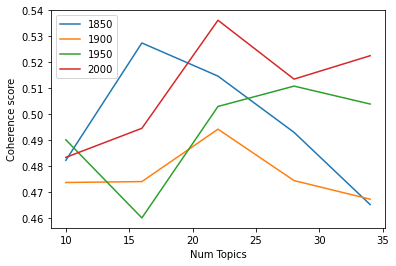

In [46]:

limit=40; start=10; step=6;
x = range(start, limit, step)
for anno in lista_anni:
    plt.plot(x, coerenza[anno])
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(lista_anni, loc='best')
plt.show()


In [62]:
ls_num_topics = []
for num_topic in range(start, limit, step):
    ls_num_topics.append(num_topic)

In [ ]:
for anno in lista_anni:
    index = coerenza[anno].index(max(coerenza[anno]))
    model = modelli[anno][index]
    model.save(r'C:\Users\user\Desktop\UNIMI\ProjectInfoRet\data\lda_{}.model'.format(anno))
    print(anno, "   numero di topic: ", ls_num_topics[index])

In [191]:
# Data una parola cerco qual è il topic più simile
tid = id2word.token2id['beer']
x = sorted(model.get_term_topics(tid, minimum_probability=0), key=lambda x: x[1], reverse = True)[0]

print(x, sorted([x for x, y in model.show_topic(x[0], topn=50)]))


(13, 0.00047542047) ['alcohol', 'argue', 'arrest', 'ask', 'base', 'blood', 'car', 'case', 'cause', 'circumstance', 'consent', 'court', 'defendant', 'determine', 'drive', 'driver', 'drug', 'evidence', 'fact', 'find', 'follow', 'give', 'interview', 'know', 'license', 'motion', 'observe', 'officer', 'people', 'person', 'police', 'probable', 'question', 'reasonable', 'result', 'right', 'search', 'state', 'statement', 'stop', 'suppress', 'take', 'tell', 'test', 'testify', 'testimony', 'time', 'traffic', 'trial', 'vehicle']
